# A k-Armed Bandit Problem

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 4

## Helper functions

In [3]:
class Bandit:
    def __init__(self, max_mean, max_std):
        self.mean = np.random.uniform(0.0, max_mean)
        self.std = np.random.uniform(0.0, max_std)
        
    def roll(self):
        return np.random.normal(self.mean, self.std)
    
    
def plot_bandits(bs):
    x = np.array(np.linspace(1, k, k))
    y = [x.mean for x in bandits]
    e = [x.std for x in bandits]
    plt.errorbar(x, y, e, linestyle='None', marker='o')
    plt.show()    
    
    
def moving_average(xs, n=100):
    cs = np.cumsum(xs, dtype=float)
    cs[n:] = cs[n:] - cs[:-n]
    return cs[n - 1:] / n    

## Define k random bandits

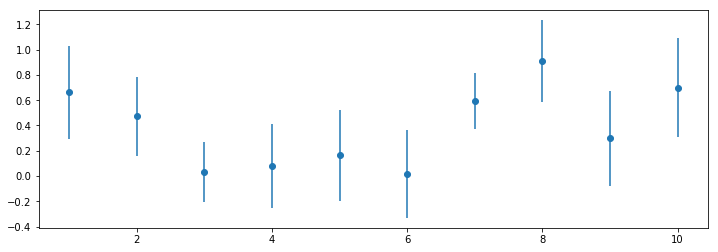

In [4]:
k = 10
bandits = [ Bandit(1.0, 0.5) for _ in range(k)]    
plot_bandits(bandits)

## Random agent

This agent select bandit randomly

In [5]:
class RandomAgent:
    
    def __init__(self, k):
        self.k = k
        
    def choose_action(self):
        """ Choose which bandit to run. 
        """
        return np.random.choice(range(self.k))
    
    
agent = RandomAgent(k)    
[agent.choose_action() for _ in range(20)]

[4, 6, 1, 5, 1, 1, 0, 0, 7, 1, 0, 0, 3, 6, 7, 1, 2, 4, 0, 9]

## Run random agent

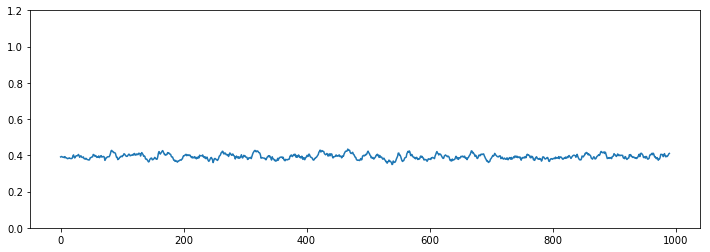

In [6]:
def run_random_agent(bandits, num_episodes):
    agent = RandomAgent(k)
    rewards = []
    for episode in range(num_episodes):
        total_reward = 0
        for j in range(100):
            a = agent.choose_action()
            reward = bandits[a].roll()
            total_reward += reward
        rewards.append(total_reward/100.0)
    return moving_average(rewards, 10)
    
    
plt.plot(run_random_agent(bandits, 1000))
plt.ylim([0, 1.2])
plt.show()

## E-Greedy agent

This agent selects, with high probability, bandit which so far got the highest reward and with small probability random bandit.

The probability is a trade off between exploitation and exploration.

In [7]:
class EGreedyAgent:
    
    def __init__(self, k, epsilon):
        self.k = k
        self.epsilon = epsilon
        self.Q = np.zeros(k)
        self.counters = np.zeros(k)
        
    def choose_action(self):
        """Select random bandit with probability epsilon.
           Or best bandit otherwise
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(self.k))
        else:
            return np.argmax(self.Q)
        
    def learn(self, action, reward):
        n = self.counters[action]
        self.Q[action] = (self.Q[action]*n + reward)/(n+1)
        self.counters[action] += 1

## Run E-Greedy agent

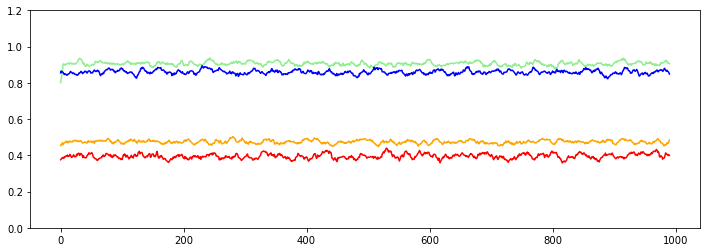

In [8]:
def run_greedy_agent(bandits, num_episodes, epsilon):
    # Agent
    agent = EGreedyAgent(k, epsilon)

    # Learn Q-Table
    rewards = []
    for episode in range(num_episodes):
        total_reward = 0
        for j in range(100):
            a = agent.choose_action()
            reward = bandits[a].roll()
            agent.learn(a, reward)
            total_reward += reward
        rewards.append(total_reward/100.0)
    return moving_average(rewards, 10)
    
    
plt.plot(run_random_agent(bandits, 1000), color='red')
plt.plot(run_greedy_agent(bandits, 1000, 0.0), color='orange')
plt.plot(run_greedy_agent(bandits, 1000, 0.01), color='lightgreen')
plt.plot(run_greedy_agent(bandits, 1000, 0.1), color='blue')
plt.ylim([0, 1.2])
plt.show()

## Learning rate

EGreedyAgent keeps average reward and counter for each action to update action reward.

To make it more efficient we can change update rule:

$$ Q'_{a} = \frac{Q_{a}*(n-1) + r}{n} = Q - \frac{Q_{a}}{n} + \frac{r}{n} = Q + \frac{1}{n}(r-Q_{a}) $$


where:
  * $Q_{a}$ - expected reward for given action (bandit)
  * a - action
  * r - current reward
  * n - counter (how many times this action was selected)
  * $r-Q$  - Error term
  * $\alpha = \frac{1}{n}$ - Learning rate
  
 Update rule:
 
 $$ Q_{a}' = Q_{a} + \alpha(r-Q_{a}) $$

In [11]:
class EGreedyAgent2:
    
    def __init__(self, k, epsilon, alpha=0.01):
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = np.zeros(k)
        
    def choose_action(self):
        """Select random bandit with probability epsilon.
           Or best bandit otherwise
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(self.k))
        else:
            return np.argmax(self.Q)
        
    def learn(self, action, reward):
        self.Q[action] = self.Q[action] + self.alpha*(reward-self.Q[action])


## Lets compare agents

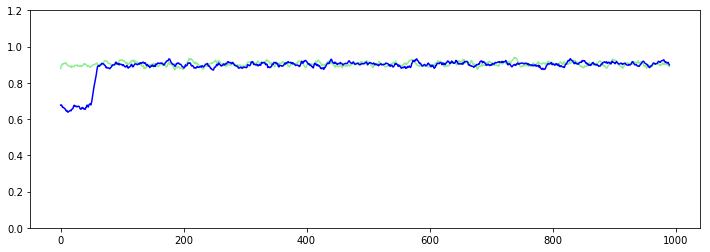

In [14]:
def run_greedy_agent2(bandits, num_episodes, epsilon):
    # Agent
    agent = EGreedyAgent2(k, epsilon, alpha=0.1)

    # Learn Q-Table
    rewards = []
    for episode in range(num_episodes):
        total_reward = 0
        for j in range(100):
            a = agent.choose_action()
            reward = bandits[a].roll()
            agent.learn(a, reward)
            total_reward += reward
        rewards.append(total_reward/100.0)
    return moving_average(rewards, 10)


plt.plot(run_greedy_agent(bandits, 1000, 0.01), color='lightgreen')
plt.plot(run_greedy_agent2(bandits, 1000, 0.01), color='blue')
plt.ylim([0, 1.2])
plt.show()

It looks that our new agents takes a little bit longer to learn correct policy. And at the end is as good as previous one.